# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, stddev,\
split, udf, count, countDistinct, desc, first
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import min as fmin
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler,\
StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import rand, col, when, concat, array, substring,lit,udf,lower,\
sum as ps_sum,count as ps_count, row_number
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH, VectorSlicer
from pyspark.sql.functions import first
from pyspark.sql.functions import split
from pyspark.sql.functions import date_format
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, \
LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import DataFrame


from functools import reduce
import random
import time
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("sparkify-app") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
#df.show(2)

### Filter data by valid userId "" and Nan value
- Dataframe contains empty `userId`, we can remove rows containing empty `userId`
- Create a user defined function to format timestamp

Schema Information
- artist: Artist name (ex. Daft Punk)
- auth: User authentication status (ex. Logged)
- firstName: User first name (ex. Colin)
- gender: Gender (ex. F or M)
- itemInSession: Item count in a session (ex. 52)
- lastName: User last name (ex. Freeman)
- length: Length of song (ex. 223.60771)
- level: User plan (ex. paid)
- location: User's location (ex. Bakersfield)
- method: HTTP method (ex. PUT)
- page: Page name (ex. NextSong)
- registration: Registration timestamp (unix timestamp) (ex. 1538173362000)
- sessionId: Session ID (ex. 29)
- song: Song (ex. Harder Better Faster Stronger)
- status: HTTP status (ex. 200)
- ts: Event timestamp(unix timestamp) (ex. 1538352676000)
- userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0)
- userId: User ID (ex. 30)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

In [7]:
df.filter(col("userId") == "").count()

8346

In [8]:
df.filter(col("userId").isNull()).count()

0

In [9]:
df.filter(col("sessionId") == "").count() 

0

In [10]:
df.filter(col("sessionId").isNull()).count()

0

In [11]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [12]:
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [13]:
valid_df = df.filter(col("userId") != "")

In [14]:
valid_df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [15]:
valid_df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [16]:
# User defined function for formating the timestamp
get_time = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [17]:
# Apply the udf on the ts column
valid_df = valid_df.withColumn("time", get_time(valid_df.ts))

In [18]:
valid_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
valid_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)



All may happened event pages
- About
- Add Friend
- Add to Playlist
- Cancel
- **Cancellation Confirmation**
- Downgrade
- Error
- Help
- Home
- Login
- Logout
- NextSong
- Register
- Roll Advert
- Save Settings
- Settings
- Submit Downgrade
- Submit Registration
- Submit Upgrade
- Thumbs Down
- Thumbs Up
- Upgrade

We may pay specific attention in **Cancellation Confirmation**, it's event that we never like to seeuser doing.<br>
We use this event to flag and create a `churn` column.

In [20]:
valid_df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [21]:
valid_df.filter(col("page") == "Cancellation Confirmation").count()

52

In [22]:
valid_df.filter(col("page") == "Cancellation Confirmation").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|               time|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 20:26:30|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...

In [23]:
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())


In [24]:
valid_churn_df = valid_df.withColumn("Churned", flag_churn("page"))

In [25]:
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [26]:
valid_churn_df = valid_churn_df.withColumn('Churn', fmax('Churned').over(userwindow))

In [27]:
churned_rate = valid_churn_df.groupby("userId").agg({"Churned": "sum"})\
.select(avg("sum(Churned)").alias("avg_sum_churn")).collect()[0]["avg_sum_churn"]


In [28]:
valid_churn_df.groupBy("userId", "Churn").count().show()


+------+-----+-----+
|userId|Churn|count|
+------+-----+-----+
|100010|    0|  381|
|200002|    0|  474|
|   125|    1|   11|
|   124|    0| 4825|
|    51|    1| 2464|
|     7|    0|  201|
|    15|    0| 2278|
|    54|    1| 3437|
|   155|    0| 1002|
|100014|    1|  310|
|   132|    0| 2304|
|   154|    0|  118|
|   101|    1| 2149|
|    11|    0|  848|
|   138|    0| 2469|
|300017|    0| 4428|
|100021|    1|  319|
|    29|    1| 3603|
|    69|    0| 1342|
|   112|    0|  292|
+------+-----+-----+
only showing top 20 rows



In [29]:
valid_churn_df.groupBy("userId", "Churned").count().show()

+------+-------+-----+
|userId|Churned|count|
+------+-------+-----+
|    73|      0|  456|
|    19|      0|  259|
|100005|      1|    1|
|200007|      0|   76|
|300007|      1|    1|
|    50|      0|  651|
|100005|      0|  215|
|200002|      0|  474|
|    30|      0| 1775|
|     8|      0|  334|
|100011|      1|    1|
|100012|      1|    1|
|     4|      0| 2442|
|200018|      0|  477|
|    65|      0| 2544|
|    13|      0| 1654|
|   101|      1|    1|
|   153|      0| 1131|
|    42|      0| 4257|
|100014|      1|    1|
+------+-------+-----+
only showing top 20 rows



In [30]:
print("churned: {:.2f}%".format(churned_rate * 100))


churned: 23.11%


In [31]:
valid_churn_df.select(["userId", "gender", "level", "page", "status", "time", "churn"]).show(30)

+------+------+-----+-----------+------+-------------------+-----+
|userId|gender|level|       page|status|               time|churn|
+------+------+-----+-----------+------+-------------------+-----+
|100010|     F| free|   NextSong|   200|2018-10-08 12:58:54|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:02:16|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:05:32|    0|
|100010|     F| free|  Thumbs Up|   307|2018-10-08 13:05:33|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:09:55|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:15:11|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:18:14|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:21:58|    0|
|100010|     F| free|Roll Advert|   200|2018-10-08 13:22:41|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:25:57|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:28:19|    0|
|100010|     F| free|   NextSong|   200|2018-10-08 13:32:28|  

In [32]:
user_counts = valid_churn_df.groupBy("auth")\
             .agg(countDistinct("userId").alias("user_counts"))\
             .sort(col("user_counts").desc())

In [33]:
user_counts.show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



Bellow we can see that 52 users have Cancelled.

In [34]:
gender_counts = valid_churn_df.groupBy("gender")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [35]:
gender_counts.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



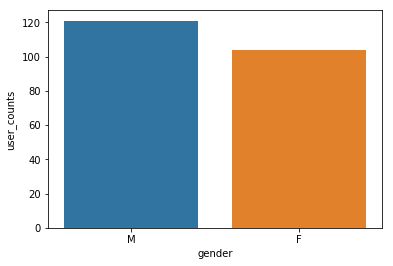

In [36]:
sns.barplot(x='gender', y='user_counts', data=gender_counts.toPandas());

There is a bit of more male gender than female gender in the dataset.
Precisely the dataset contains 121 male and 104 female.

In [37]:
iteminsession_counts = valid_churn_df.select(countDistinct(col("itemInSession")).alias("item_counts"))

In [38]:
iteminsession_counts.show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



In [39]:
length_df = valid_churn_df.select(col("length")).dropna()

In [40]:
length_df.show()

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
|208.29995|
|260.46649|
|185.44281|
|134.47791|
| 229.8771|
|223.58159|
|201.06404|
|246.69995|
|168.64608|
| 166.1122|
|222.22322|
|229.77261|
|283.74159|
|223.92118|
|250.93179|
+---------+
only showing top 20 rows



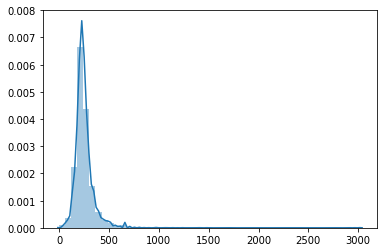

In [41]:
sns.distplot(length_df.toPandas());

Length looks like a  gaussian distribution with long write tail.
Most of length values are concentrated between 0 and 500.

In [42]:
level_counts = valid_churn_df.groupBy("level")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [43]:
level_counts.show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [44]:
# Interaction between paid and free users
valid_churn_df.filter(valid_churn_df["level"] == "paid") \
      .select("userId").dropDuplicates() \
      .intersect(valid_churn_df.filter(valid_churn_df["level"] == "free") \
      .select("userId").dropDuplicates() \
      ).count()

135

There are more  free user than paid one. 
195 free users and 165 free users.  There also 135 users using paid and free level

In [45]:
location_counts = valid_churn_df.groupBy("location")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())


In [46]:
location_counts_pd = location_counts.toPandas()

In [47]:
location_counts_pd.head()

,location,user_counts
0,"Los Angeles-Long Beach-Anaheim, CA",16
1,"New York-Newark-Jersey City, NY-NJ-PA",15
2,"Phoenix-Mesa-Scottsdale, AZ",7
3,"Dallas-Fort Worth-Arlington, TX",7
4,"St. Louis, MO-IL",6


In [48]:
# Split city and state
location_counts_pd = location_counts_pd.join(location_counts_pd['location'].str.split(',',expand=True)\
                                        .rename(columns={0:'city', 1:'state'})).drop('location',axis=1)


In [49]:
location_counts_pd.head()

,user_counts,city,state
0,16,Los Angeles-Long Beach-Anaheim,CA
1,15,New York-Newark-Jersey City,NY-NJ-PA
2,7,Phoenix-Mesa-Scottsdale,AZ
3,7,Dallas-Fort Worth-Arlington,TX
4,6,St. Louis,MO-IL


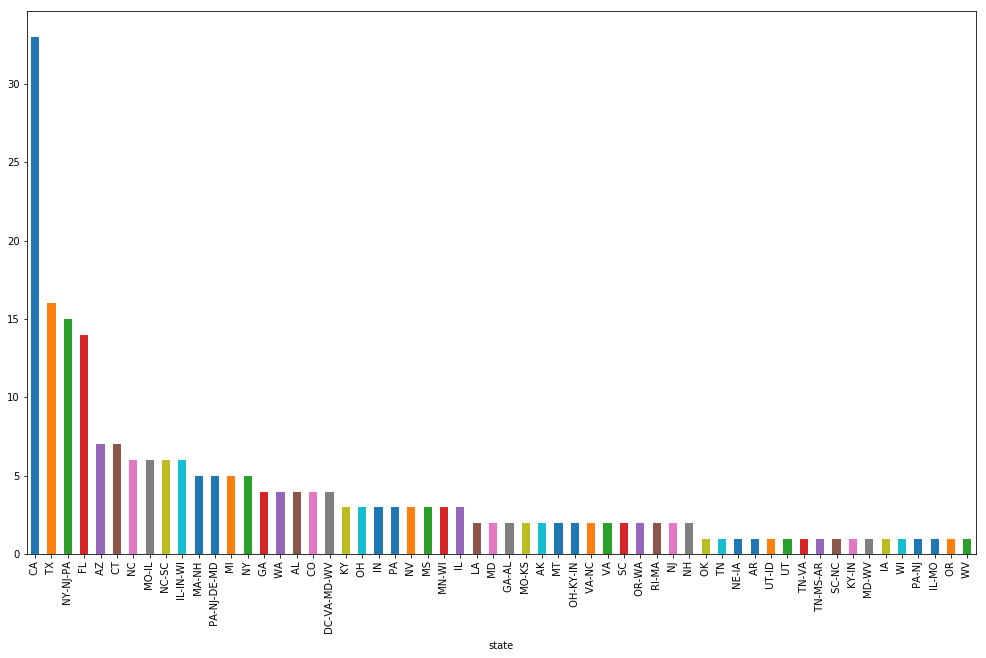

In [50]:
location_counts_pd.groupby('state')['user_counts'].sum().sort_values(ascending=False)\
.plot(kind='bar', figsize=(17,10))
plt.show()

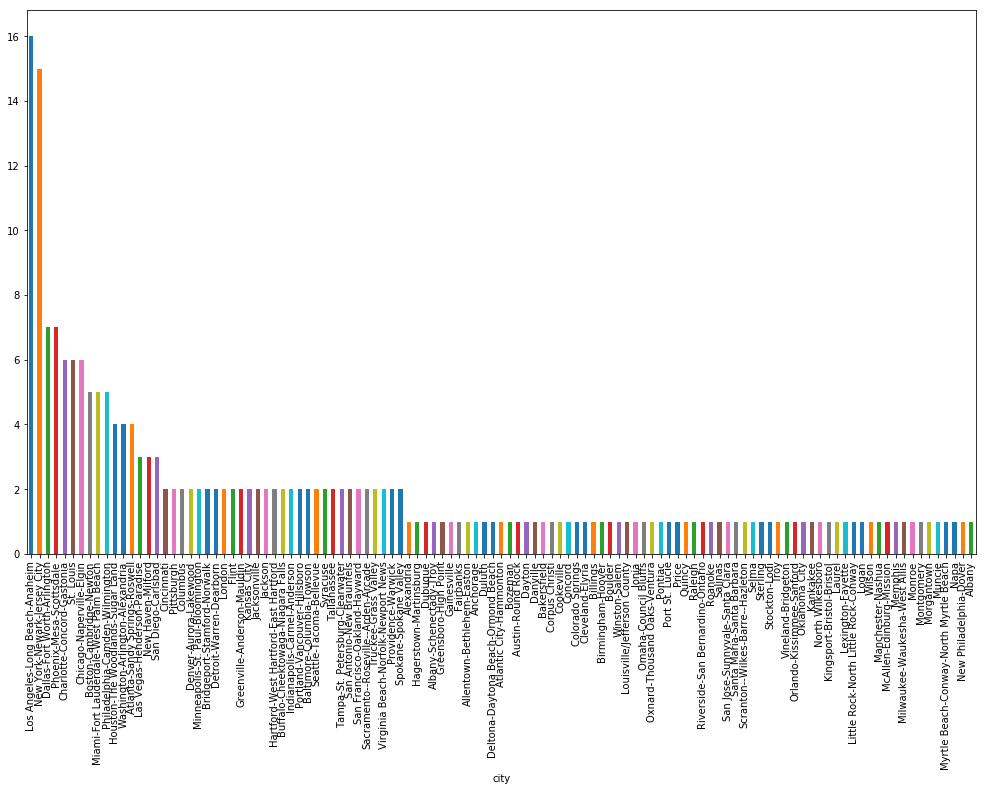

In [51]:
location_counts_pd.groupby('city')['user_counts'].sum().sort_values(ascending=False)\
.plot(kind='bar', figsize=(17,10))
plt.show()

- California and Texas are the most representive state in the dataset
- Users  most live in Los Angeles, New york city and Dallas

In [52]:
page_counts = valid_churn_df.groupBy("page")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [53]:
page_counts.show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|        225|
|                Home|        223|
|           Thumbs Up|        220|
|     Add to Playlist|        215|
|              Logout|        213|
|         Roll Advert|        207|
|          Add Friend|        206|
|         Thumbs Down|        203|
|            Settings|        195|
|                Help|        192|
|             Upgrade|        168|
|               About|        155|
|           Downgrade|        154|
|       Save Settings|        132|
|      Submit Upgrade|        131|
|               Error|        117|
|              Cancel|         52|
|Cancellation Conf...|         52|
|    Submit Downgrade|         49|
+--------------------+-----------+



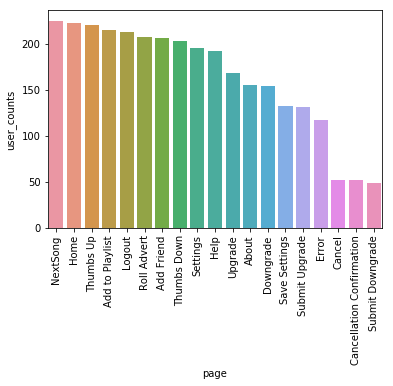

In [54]:
sns.barplot(x="page", y="user_counts", data=page_counts.toPandas())
plt.xticks(rotation='vertical')
plt.show()

Most of users are in NextSong, Home, Thumbs Up or Add to Playlist When we have few that cancel, or in Cancellation Confirmation or Submit Downgrade

In [55]:
useragent_counts = valid_churn_df.groupBy("userAgent")\
                .agg(countDistinct("userId").alias("user_counts"))\
                .sort(col("user_counts").desc())

In [56]:
useragent_counts.show()

+--------------------+-----------+
|           userAgent|user_counts|
+--------------------+-----------+
|"Mozilla/5.0 (Win...|         24|
|Mozilla/5.0 (Wind...|         18|
|"Mozilla/5.0 (Mac...|         16|
|"Mozilla/5.0 (Mac...|         12|
|"Mozilla/5.0 (Mac...|         12|
|"Mozilla/5.0 (Mac...|         10|
|"Mozilla/5.0 (Win...|         10|
|Mozilla/5.0 (Maci...|          9|
|"Mozilla/5.0 (iPh...|          8|
|"Mozilla/5.0 (Mac...|          7|
|"Mozilla/5.0 (Win...|          7|
|Mozilla/5.0 (Wind...|          7|
|"Mozilla/5.0 (Win...|          5|
|"Mozilla/5.0 (iPh...|          4|
|"Mozilla/5.0 (X11...|          4|
|Mozilla/5.0 (Wind...|          4|
|Mozilla/5.0 (X11;...|          4|
|"Mozilla/5.0 (Win...|          4|
|"Mozilla/5.0 (Win...|          4|
|"Mozilla/5.0 (Win...|          4|
+--------------------+-----------+
only showing top 20 rows



In [57]:
def get_browser(x):
    """
    get the browser name in user agent
    Input x (str): userAgent
    Output str: browser name like `Firefox`
    """
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN


In [58]:
type(useragent_counts)

pyspark.sql.dataframe.DataFrame

In [59]:
useragent_counts_pd = useragent_counts.toPandas()

In [60]:
get_browser_udf = udf(get_browser)

In [61]:
useragent_counts1 = useragent_counts.withColumn("browser",  get_browser_udf("userAgent"))

In [62]:
useragent_counts1.show()

+--------------------+-----------+-------+
|           userAgent|user_counts|browser|
+--------------------+-----------+-------+
|"Mozilla/5.0 (Win...|         24| Chrome|
|Mozilla/5.0 (Wind...|         18|Firefox|
|"Mozilla/5.0 (Mac...|         16| Chrome|
|"Mozilla/5.0 (Mac...|         12| Chrome|
|"Mozilla/5.0 (Mac...|         12| Safari|
|"Mozilla/5.0 (Win...|         10| Chrome|
|"Mozilla/5.0 (Mac...|         10| Safari|
|Mozilla/5.0 (Maci...|          9|Firefox|
|"Mozilla/5.0 (iPh...|          8| Safari|
|"Mozilla/5.0 (Win...|          7| Chrome|
|"Mozilla/5.0 (Mac...|          7| Chrome|
|Mozilla/5.0 (Wind...|          7|     IE|
|"Mozilla/5.0 (Win...|          5| Chrome|
|"Mozilla/5.0 (Win...|          4| Chrome|
|Mozilla/5.0 (Wind...|          4|Firefox|
|"Mozilla/5.0 (X11...|          4| Chrome|
|"Mozilla/5.0 (Win...|          4| Chrome|
|Mozilla/5.0 (X11;...|          4|Firefox|
|"Mozilla/5.0 (Win...|          4| Chrome|
|"Mozilla/5.0 (iPh...|          4| Safari|
+----------

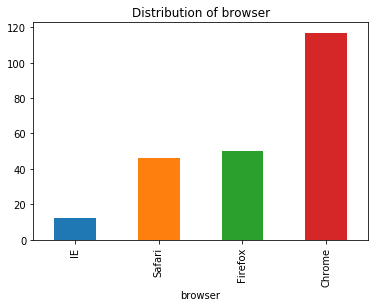

In [63]:
plt.title("Distribution of browser")
useragent_counts1.toPandas().groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar')
plt.show()

We see that Chrome browser is far most used, it's followed by firefox and safari.
IE is very little bit used.

In [64]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
                 'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows',
                 'Windows NT 6.1': 'Windows', 'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows',
                 'X11': 'Linux'}

In [65]:
useragent_counts1_pd = useragent_counts1.toPandas()

In [66]:
useragent_counts1_pd['platform'] = useragent_counts1_pd['userAgent'].str.extract(r'\(([^\)]*)\)')[0]\
                                   .str.split(';').str[0].map(platform_dict)


In [67]:
useragent_counts1_pd.head()

,userAgent,user_counts,browser,platform
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",24,Chrome,Windows
1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,18,Firefox,Windows
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",16,Chrome,Mac
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",12,Chrome,Mac
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",12,Safari,Mac


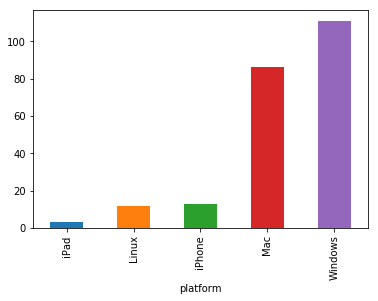

In [68]:
useragent_counts1_pd.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar')
plt.show()

In [69]:
time_dt = valid_churn_df.select("time", "userId")

In [70]:
time_dt.show()

+-------------------+------+
|               time|userId|
+-------------------+------+
|2018-10-01 00:01:57|    30|
|2018-10-01 00:03:00|     9|
|2018-10-01 00:06:34|    30|
|2018-10-01 00:06:56|     9|
|2018-10-01 00:11:16|    30|
|2018-10-01 00:11:18|     9|
|2018-10-01 00:14:46|     9|
|2018-10-01 00:14:59|    30|
|2018-10-01 00:15:05|    30|
|2018-10-01 00:18:04|    30|
|2018-10-01 00:19:06|     9|
|2018-10-01 00:19:10|     9|
|2018-10-01 00:20:18|    30|
|2018-10-01 00:22:55|     9|
|2018-10-01 00:22:56|     9|
|2018-10-01 00:24:01|    30|
|2018-10-01 00:26:16|     9|
|2018-10-01 00:27:48|    74|
|2018-10-01 00:28:07|    30|
|2018-10-01 00:29:04|     9|
+-------------------+------+
only showing top 20 rows



In [71]:
time_dt_pd = time_dt.toPandas()

In [72]:
time_dt_pd['time'] = pd.to_datetime(time_dt_pd['time'])

In [73]:
time_dt_pd.head()

,time,userId
0,2018-10-01 00:01:57,30
1,2018-10-01 00:03:00,9
2,2018-10-01 00:06:34,30
3,2018-10-01 00:06:56,9
4,2018-10-01 00:11:16,30


In [74]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_dt_pd['weekday'] = time_dt_pd['time'].dt.weekday.map(weekday_dict)
time_dt_pd['day'] = time_dt_pd['time'].dt.day
time_dt_pd['hour'] = time_dt_pd['time'].dt.hour

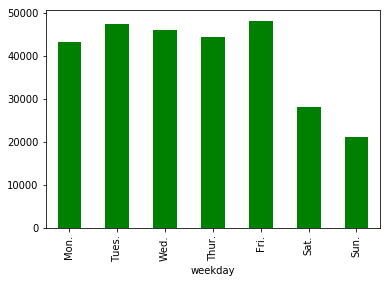

In [75]:
time_dt_pd.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#008000')

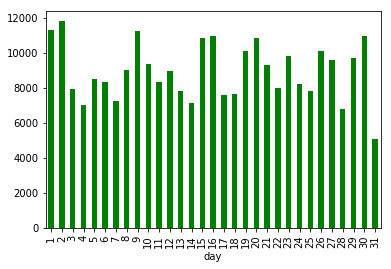

In [76]:
time_dt_pd.groupby('day')['userId'].count().plot(kind='bar',color='#008000')


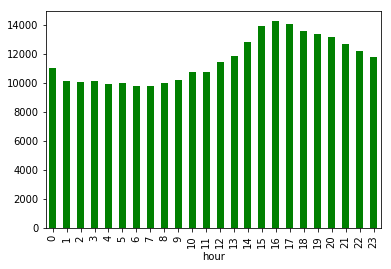

In [77]:
time_dt_pd.groupby('hour')['userId'].count().plot(kind='bar',color="#008000")

Users' behaviors are periodic, they use Sparkify more often in workdays than weekend; In one single day, they use Sparkify more often after 14 o'clock.


**Difference of each feature in two stage analysis**

In [78]:
label_churn = udf(lambda x: "Churn" if x == 1 else "Not churn")
user_churn = valid_churn_df.groupby("userId").max("Churn").withColumnRenamed("max(Churn)", "Churned")

In [79]:
def churned(df):
    """Create new Churned on pyspark df
    Input 
     df spark: dataframe
     
    Output 
     spark df 
    """
    results = df.withColumn("Churned", label_churn("Churn"))
    return results

In [80]:
valid_churn_df = churned(valid_churn_df)

- auth

In [81]:
valid_churn_df.select("auth", "Churned").show()

+---------+---------+
|     auth|  Churned|
+---------+---------+
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
|Logged In|Not churn|
+---------+---------+
only showing top 20 rows



In [82]:
valid_churn_df.dropDuplicates(["userId"]).groupby(["Churned", "auth"]).count().sort("Churned").show()

+---------+---------+-----+
|  Churned|     auth|count|
+---------+---------+-----+
|    Churn|Logged In|   52|
|Not churn|Logged In|  173|
+---------+---------+-----+



It seems that ***auth*** has not effect in Churned

- gender

In [83]:
valid_churn_df.dropDuplicates(["userId", "gender"]).groupby(["Churned", "gender"]).count().sort("Churned").show()

+---------+------+-----+
|  Churned|gender|count|
+---------+------+-----+
|    Churn|     F|   20|
|    Churn|     M|   32|
|Not churn|     M|   89|
|Not churn|     F|   84|
+---------+------+-----+



In [84]:
32+89, 20+84

(121, 104)

In [85]:
stats, p_value = proportions_ztest([20, 32], [104, 121])

In [86]:
stats, p_value

(-1.2800974409737422, 0.20051086855629463)

In [87]:
male_churn_rate = 32/121
female_churn_rate = 20/104

In [88]:
male_churn_rate, female_churn_rate

(0.2644628099173554, 0.19230769230769232)

We see that male churn rate is $0.26$ while female churn rate is $0.19$. But p_value of z_test is 0.2 which is fa above 0.05. So we can affirm that gender has no effect in Churn or Not Churn.

- length

In [89]:
#from pyspark.sql.functions import stddev

In [90]:
valid_churn_df.select(["Churned", "length"]).groupby(["Churned"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                     fmax('length').alias('max_length'),
                                                                     fmin('length').alias('min_length')).show()



+---------+------------------+------------------+----------+----------+
|  Churned|       mean_length|      stdev_length|max_length|min_length|
+---------+------------------+------------------+----------+----------+
|    Churn|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|Not churn|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+---------+------------------+------------------+----------+----------+



- level 

In [91]:
#valid_churn_df, _ = churned(valid_churn_df, "level")

In [92]:
valid_churn_df.dropDuplicates(["userId"]).groupby(["Churned", "level"]).count().sort("Churned").show()

+---------+-----+-----+
|  Churned|level|count|
+---------+-----+-----+
|    Churn| paid|    8|
|    Churn| free|   44|
|Not churn| free|  133|
|Not churn| paid|   40|
+---------+-----+-----+



In [93]:
#44+133

In [94]:
zstats, pvalue = proportions_ztest([44, 8], [177, 48])

In [95]:
zstats, pvalue

(1.194176507959015, 0.23240893045643263)

In [96]:
paid_churn_rate, free_churn_rate = 8/48, 44/177

In [97]:
paid_churn_rate, free_churn_rate

(0.16666666666666666, 0.24858757062146894)

It seems that level have no  effect in churn because pvalue ($0.25$)  is far above $0.05$

- location

In [98]:
def normalize_data(groupby_data):
    """Normalize a grouped dataframe by min max
    Input grouped data frame
    Output 
    
    """
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churned').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]: 'results'})
    return df



In [99]:
split_city_state = split(valid_churn_df['location'], ',')

In [100]:
valid_churn_df = valid_churn_df.withColumn('state', split_city_state.getItem(1))


In [101]:
#valid_churn_df, _ = churned(valid_churn_state_df, "state")

In [102]:
state_data = valid_churn_df.dropDuplicates(["userId"]).groupby(["state","Churned"])\
            .count().sort("state").toPandas()

In [103]:
normalize_state_data = normalize_data(state_data)


In [104]:
normalize_state_data.head()

,state,Churned,results
0,AK,Churn,0.000000
1,AK,Not churn,0.074074
2,AL,Churn,0.333333
3,AL,Not churn,0.074074
4,AR,Churn,0.166667


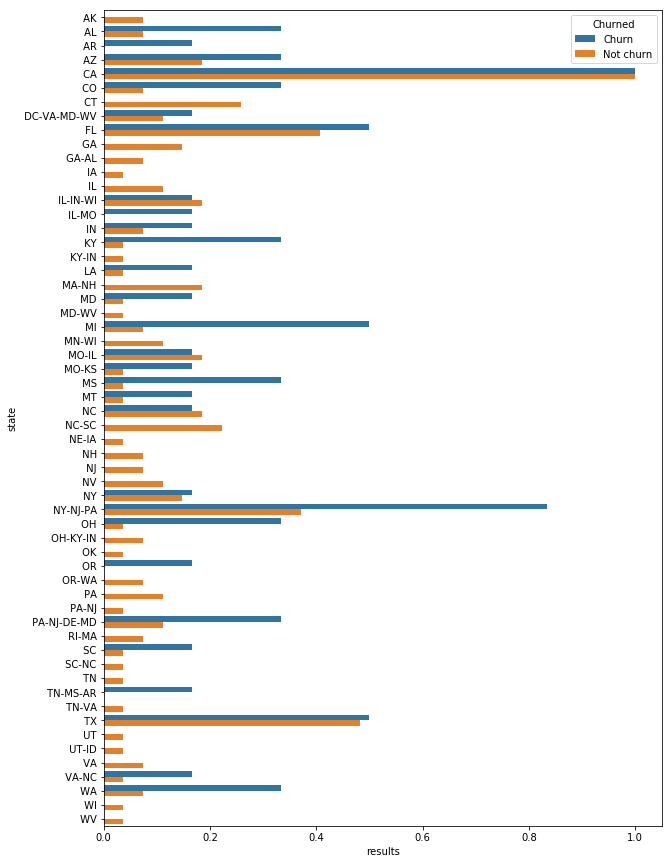

In [105]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="results", y="state", hue="Churned",
            data=normalize_state_data, ax=ax)
plt.show()

- page

In [106]:
valid_churn_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churned: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- state: string (nullable = true)



In [107]:
#valid_churn_df, _ = churned(valid_churn_state_df, "page")

In [108]:
valid_churn_df.select(["Churned", "page"]).groupby(["Churned", "page"]).count().sort("page").show()

+---------+--------------------+------+
|  Churned|                page| count|
+---------+--------------------+------+
|Not churn|               About|   439|
|    Churn|               About|    56|
|Not churn|          Add Friend|  3641|
|    Churn|          Add Friend|   636|
|    Churn|     Add to Playlist|  1038|
|Not churn|     Add to Playlist|  5488|
|    Churn|              Cancel|    52|
|    Churn|Cancellation Conf...|    52|
|Not churn|           Downgrade|  1718|
|    Churn|           Downgrade|   337|
|Not churn|               Error|   220|
|    Churn|               Error|    32|
|    Churn|                Help|   239|
|Not churn|                Help|  1215|
|Not churn|                Home|  8410|
|    Churn|                Home|  1672|
|Not churn|              Logout|  2673|
|    Churn|              Logout|   553|
|Not churn|            NextSong|191714|
|    Churn|            NextSong| 36394|
+---------+--------------------+------+
only showing top 20 rows



In [109]:
page_data = valid_churn_df.select(["Churned", "page"]).groupby(["Churned", "page"]).count().sort("page").toPandas()

In [110]:
page_data = normalize_data(page_data)

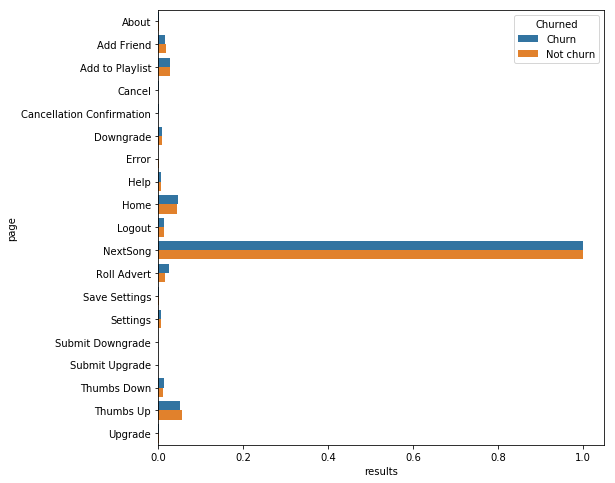

In [111]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x="results", y="page", hue="Churned",
            data=page_data,ax=ax)
plt.show()

NextSong,Thumbs Up/Down, Home, Add to Playlist page's seems to have effect on Churn or not.

- userAgent

In [112]:
browser = udf(lambda x : get_browser(x))

In [113]:
valid_churn_df = valid_churn_df.withColumn('browser', browser(valid_churn_df.userAgent))

In [114]:
#df_browser, _ = churned(df_browser, "browser")

In [115]:
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])

In [116]:
valid_churn_df = valid_churn_df.withColumn('platform', get_platform(valid_churn_df.userAgent))

In [117]:
#df_platform, _ = churned(df_platform, "platform")

In [118]:
browser_data = valid_churn_df.select(["browser","Churned"]).groupby([ "browser", "Churned"]).count().sort("browser").toPandas()

In [119]:
platform_data = valid_churn_df.select(["platform","Churned"]).groupby([ "platform", "Churned"]).count().sort("platform").toPandas()

In [120]:
browser_data = normalize_data(browser_data)

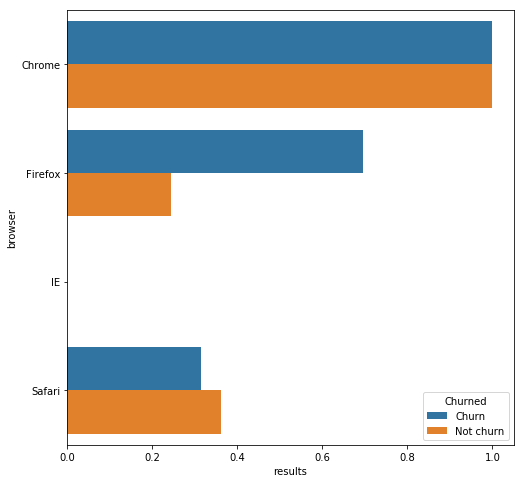

In [121]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="results", y="browser", hue="Churned", data=browser_data, ax=ax)
plt.show()

In [122]:
platform_data = normalize_data(platform_data)

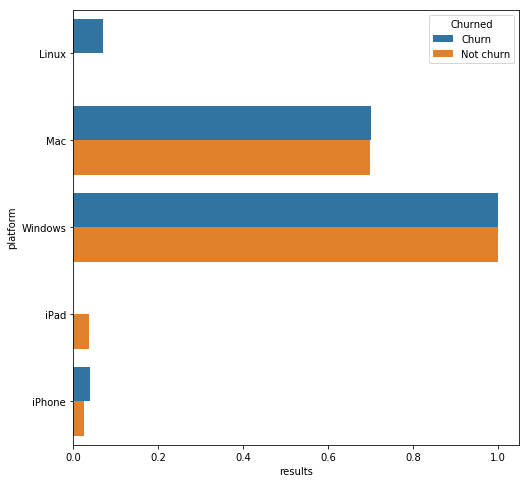

In [123]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="results", y="platform", hue="Churned",
            data=platform_data, ax=ax)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

We can perform some feature engineering
- Categorical Features (need label encoding)
    - gender
    - level
    - browser
    - platform
- Numerical Features
    - mean,max,min,std of length of users
    - numbers of these item in page (NextSong,ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert)
    - number of unique songs and total songs of users
    - number of unique artists of users
    - percentage of operations after 15th in a month
    - percentage of operations in workday

- Categorical Features



In [124]:
valid_churn_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churned: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)



- ***Categorical variable***

In [125]:
def encode_cat_col(colname):
    '''
    Transform categorical items
    to number
    Input
     colname str: Categorical col name to encode
    Output
     df containing label encode
     
    '''
    temp = valid_churn_df.select([colname]).dropDuplicates().toPandas()
    dict_label = {val: str(idx) for idx, val in enumerate(temp[colname].tolist())}
    results = valid_churn_df.dropDuplicates(['userId']).select(['userId', colname])\
    .replace(dict_label, subset=colname)
    return results



In [126]:
def get_categorical_features():
    '''
    Join all categorical features together
    '''
    feature_gender =  encode_cat_col('gender')
    feature_level =   encode_cat_col('level')
    feature_browser =  encode_cat_col('browser')
    feature_platform = encode_cat_col('platform')
    
    results = feature_gender.join(feature_level, on='userId', how='inner')\
                            .join(feature_browser, on='userId', how='inner')\
                            .join(feature_platform, on='userId', how='inner')
    return results

In [127]:
categorical_feature = get_categorical_features()

In [128]:
categorical_feature.show(3)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
|   125|     1|    0|      3|       3|
+------+------+-----+-------+--------+
only showing top 3 rows



- ***Numerical variable***

In [129]:
def get_numerical_features(df):
    """Join  all numerical features
    Input
     df dataframe 
    Output
     all numerical features
    """
    feature_length = df.select(["userId", "length"]).groupby(["userId"])\
                     .agg(avg('length').alias('mean_length'), stddev('length').alias('stdev_length'),\
                     fmax('length').alias('max_length'), fmin('length').alias('min_length'))
    page_count = df.select(["userId","page"]).groupby(["userId","page"]).count()
    tmp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    tmp1 = tmp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down',
                    'Add to Playlist', 'Add Friend', 'Roll Advert'])
    columns = tmp1.columns[1:]
    feature_page = tmp1.withColumn('total', sum([col(column) for column in columns])) 
    # Unique songs number
    feature_nunique_song = df.filter(df["page"] == 'NextSong')\
                             .select(["userId","song"])\
                             .dropDuplicates(["userId","song"])\
                             .groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    feature_ntotal_song = df.filter(df["page"] == 'NextSong')\
                                    .select(["userId","song"])\
                                    .groupby(["userId"]).count()
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId", "count as ntotal_song")
    feature_nunique_artist = df.filter(df["page"] == 'NextSong')\
                            .select(["userId", "artist"])\
                            .dropDuplicates(["userId", "artist"])\
                            .groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId", "count as nunique_artist")
    # Create day num and week day
    df = df.withColumn('day_num', date_format('time', 'd'))
    df = df.withColumn('week_day', date_format('time', 'u'))

    day_count = df.filter(df["day_num"] >= 15).select(['userId'])\
                .groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    total_count = df.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    
    dayofweek_count = df.filter(df['week_day'] < 5).select(['userId'])\
                     .groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"])\
                               .select(col("userId"), (col("day.day_count") / col("total.total_count"))\
                               .alias("month_percentage")))
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"])\
                              .select(col("userId"), (col("day.dayofweek_count") / col("total.total_count"))\
                              .alias("week_percentage")))
    
    results = feature_length.join(feature_page,on='userId', how='inner')\
                            .join(feature_nunique_song, on='userId', how='inner')\
                            .join(feature_ntotal_song, on='userId', how='inner')\
                            .join(feature_nunique_artist, on='userId', how='inner')\
                            .join(feature_percentage_month, on='userId',how='inner')\
                            .join(feature_percentage_week,on='userId',how='inner')
    return results


In [130]:
num_features = get_numerical_features(valid_churn_df)

In [131]:
num_features.show()

+------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+-----+------------+-----------+--------------+-------------------+------------------+
|userId|       mean_length|      stdev_length|max_length|min_length|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|total|nunique_song|ntotal_song|nunique_artist|   month_percentage|   week_percentage|
+------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+-----+------------+-----------+--------------+-------------------+------------------+
|100010|  243.421444909091|  79.5156544698794| 538.85342|  52.27057|     275|       17|          5|              7|         4|         52|  360|         269|        275|           252| 0.4120734908136483|0.5485564304461942|
|200002|242.91699209302305|   75.447490312729| 592.06485|  26.56608|     387|       21|          6|     

- Label

In [132]:
label = valid_churn_df.select(['userId','Churn']).dropDuplicates()

In [133]:
label.show()

+------+-----+
|userId|Churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [134]:
def create_data(df):
    """Merge features and labels
    """
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features(df)
    label = df.select(['userId','Churn']).dropDuplicates()
    results = categorical_feature.join(numerical_feature, on='userId', how='inner')\
            .join(label, on='userId', how='inner')
    
    
    for colname in results.columns[1:5]:
        results = results.withColumn(colname, results[colname].cast(IntegerType()))
    for colname in results.columns[5:-1]:
        results = results.withColumn(colname, results[colname].cast(FloatType()))
    # Fill NaN
    results = results.na.fill(0)
    results = results.withColumnRenamed("Churn", "label")
  
    return results


In [135]:
data = create_data(valid_churn_df)

In [136]:
data.show()

+------+------+-----+-------+--------+-----------+------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+------+------------+-----------+--------------+----------------+---------------+-----+
|userId|gender|level|browser|platform|mean_length|stdev_length|max_length|min_length|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert| total|nunique_song|ntotal_song|nunique_artist|month_percentage|week_percentage|label|
+------+------+-----+-------+--------+-----------+------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+------+------------+-----------+--------------+----------------+---------------+-----+
|100010|     0|    0|      1|       1|  243.42145|   79.515656|  538.8534|  52.27057|   275.0|     17.0|        5.0|            7.0|       4.0|       52.0| 360.0|       269.0|      275.0|         252.0|       0.4120735|     0.54855645|    0|
|200002|     1|    0|      1|   

In [137]:
data.write.save('final_data.json', format='json',
                mode='overwrite', header=True)

In [138]:
final_data = spark.read.json('final_data.json')

In [139]:
columns = final_data.columns
columns.remove('label')
columns.remove('userId')

In [140]:
categorical_features = ['gender','level','browser','platform']
numerical_features = [colname for colname in columns if colname not in categorical_features]

In [141]:
final_data.toPandas().shape

(203, 22)

In [142]:
#final_data = final_data.withColumnRenamed("Churn", "label")

In [143]:
numerical_features

['Add Friend',
 'Add to Playlist',
 'NextSong',
 'Roll Advert',
 'Thumbs Down',
 'Thumbs Up',
 'max_length',
 'mean_length',
 'min_length',
 'month_percentage',
 'ntotal_song',
 'nunique_artist',
 'nunique_song',
 'stdev_length',
 'total',
 'week_percentage']

In [144]:
def create_pipeline(df):
    """Create a pipeline that automates process
    - Create a vector assembler on features
    - Create  label
    - Standard scaling
    
    
    Input 
        df: spark dataframe to process
        
    Output 
        labeled dataframe
    
    """
    vector = VectorAssembler(inputCols=numerical_features,
                             outputCol='numerical_features')
    tmp = vector.transform(df)
    scaler = StandardScaler(withMean=True, withStd=True,
                            inputCol='numerical_features',
                            outputCol='features_scaled')
    scaler_fit = scaler.fit(tmp)
    result_scaled = scaler_fit.transform(tmp)

    # Add categorical features to feature vector

    vector = VectorAssembler(inputCols=categorical_features + ['features_scaled'],
                             outputCol='all_features')
    #pipeline = Pipeline(stages=[vector, scaler, clf])

    result_scaled = vector.transform(result_scaled)
    final_result = result_scaled.select(result_scaled.label, 
                                        result_scaled.all_features.alias('features'))
    
    return final_result

In [145]:
data = create_pipeline(final_data)

In [146]:
train, test = data.randomSplit([0.7, 0.3], seed=12345)

In [147]:
train.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)



- We are using smote srategy for unversampling.
- ***SMOTE*** introduce some noise in creating synthetic minority instances and serves as a more robust solution than simply resample

In [148]:
# source code https://medium.com/@haoyunlai/smote-implementation-in-pyspark-76ec4ffa2f1d
def smote(vectorized_sdf, smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == 1]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == 0]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",
                                      seed=smote_config["seed"],
                                      bucketLength=smote_config["bucketLength"])
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float("inf"),
                                                      distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= smote_config["k"])

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = udf(lambda arr: random.uniform(0, 1)*(arr[0]-arr[1]), VectorUDT())
    add_vector_udf = udf(lambda arr: arr[0]+arr[1], VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(smote_config["multiplier"]):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected.withColumn("rand", rand()).withColumn('max_rand', fmax('rand').over(over_original_rows_no_order))\
                            .where(col('rand') == col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel.select('*', subtract_vector_udf(array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
        df_vec_modified = df_vec_diff.select('*', add_vector_udf(array('datasetA.features', 'vec_diff')).alias('features'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c, col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.unionAll, res)
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(vectorized_sdf.select(dfunion.columns))
    
    return oversampled_df

In [149]:
smote_config = {"seed":12345, "bucketLength":3.0,
                "multiplier":4, "k": 4}

In [150]:
train_smote = smote(train, smote_config)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances


In [151]:
train_smote.groupby("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    0|  121|
|    1|  125|
+-----+-----+



In [152]:
test.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.0,0.0,4.0,...|
|    0|[0.0,0.0,1.0,1.0,...|
|    0|[0.0,0.0,1.0,3.0,...|
|    0|[0.0,0.0,1.0,3.0,...|
|    0|[0.0,0.0,3.0,3.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    0|[0.0,0.0,3.0,4.0,...|
|    0|[0.0,1.0,3.0,4.0,...|
|    0|[1.0,0.0,1.0,1.0,...|
|    0|[1.0,0.0,1.0,3.0,...|
|    0|[1.0,0.0,3.0,3.0,...|
|    0|[1.0,0.0,3.0,3.0,...|
|    0|[1.0,0.0,3.0,4.0,...|
|    1|[0.0,0.0,2.0,4.0,...|
|    1|[0.0,0.0,3.0,4.0,...|
|    1|[0.0,1.0,0.0,4.0,...|
|    1|[1.0,0.0,0.0,3.0,...|
|    1|[1.0,0.0,1.0,3.0,...|
+-----+--------------------+
only showing top 20 rows



In [153]:
train_smote.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.56266828230879...|    1|
|[1.0,0.0,1.0,1.0,...|    1|
|[0.0,-0.937276701...|    1|
|[0.0,1.0,3.0,4.16...|    1|
|[1.0,0.0,-0.18132...|    1|
|[0.0,0.0,-2.87537...|    1|
|[0.0,0.0,0.0,2.41...|    1|
|[0.0,0.0,3.0,3.0,...|    1|
|[-0.2042538385705...|    1|
|[1.02047397188417...|    1|
|[0.0,-0.017468095...|    1|
|[1.0,0.0,5.854979...|    1|
|[0.0,-0.374451276...|    1|
|[1.93871466236497...|    1|
|[1.75913250024308...|    1|
|[-0.4260122885381...|    1|
|[1.0,1.4913651305...|    1|
|[0.0,0.0,0.0,2.89...|    1|
|[0.0,0.0,0.0,4.07...|    1|
|[-0.5432904618409...|    1|
+--------------------+-----+
only showing top 20 rows



# Modelingvector
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [154]:
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=7)
clf_RF = RandomForestClassifier(seed=7)
clf_GB = GBTClassifier(maxIter=10)
#clf_SVM = LinearSVC()

In [155]:
#pipeline = Pipeline(stages=[smote(smote_config=smote_config), clf_LR])


In [156]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [157]:
models = [clf_LR, clf_DT, clf_RF, clf_GB]

In [158]:
def train_models(model_list, dtrain, dtest):
    """Train models and compute f1 score
    Input:
        models: list containing classifiers
        dtrain: training dataframe
        dtest: test dataframe
    Output:
        dataframe containing f1 score,
        training time and prediction time
    """
    # collect results on the learners
    all_results = {}
    for clf in model_list:
        model_results = {}
        # get the classifier name
        clf_name = clf.__class__.__name__


        # fit the dataset
        print(f'{clf_name} is training...')
        start = time.time() 
        model = clf.fit(dtrain)
        end = time.time() 
        model_results['train_time'] = round(end-start,6)

        # predict
        print(f'{clf_name} is predicting...')
        start = time.time() 
        pred_test = model.transform(dtest)
        end = time.time()
        model_results['pred_time'] = round(end-start,6)

        #metrics
        print(f'{clf_name} is evaluating...')    
        model_results['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),
                                                      {evaluator.metricName: 'f1'})
        print('Test F1-score: ',model_results['f1_test'])
        all_results[clf_name] = model_results

    all_results_df = pd.DataFrame(all_results)
    all_results_df.to_csv('baseline.csv')
    return all_results_df

In [159]:
all_results_df = train_models(models, train_smote, test)

LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.627650206597575
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.6623673809028501
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.6366431542774463
GBTClassifier is training...
GBTClassifier is predicting...
GBTClassifier is evaluating...
Test F1-score:  0.668615984405458


In [160]:
all_results_df

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GBTClassifier
f1_test,0.627650,0.662367,0.636643,0.668616
pred_time,0.076929,0.142952,0.116230,0.086458
train_time,435.117308,289.801555,321.166523,639.131178


In [164]:
params = {param[0].name: param[1] for param in clf_DT.extractParamMap().items()}

In [165]:
params

{'seed': 7,
 'rawPredictionCol': 'rawPrediction',
 'probabilityCol': 'probability',
 'predictionCol': 'prediction',
 'labelCol': 'label',
 'featuresCol': 'features',
 'maxDepth': 5,
 'maxBins': 32,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'gini'}

Decision trees get best **f1-score** with smaller training time. Due to closness of Decison tree and random forest I have chosen to combine Logistic regression and Decision trees to create a stacking model and finaly train stacked model with Random forest.

In the next I tune Decision tree and Logistic Regression stack their probability as features. Finally I tune random forest model on stacked data.

- Decision Trees

In [169]:
paramGrid_DT = ParamGridBuilder()\
             .addGrid(clf_DT.maxDepth, [10, 20, 30])\
             .addGrid(clf_DT.maxBins, [30, 40, 80])\
             .build()

In [171]:
crossval_DT = CrossValidator(estimator=clf_DT,
                          estimatorParamMaps=paramGrid_DT,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [172]:
start = time.time()
cvModel_DT = crossval_DT.fit(train_smote)
end = time.time()
print(f'Model tuning is done, spent {end-start}s')

Model tuning is done, spent 4457.914426326752s


In [173]:
prediction_DT = cvModel_DT.transform(test)

In [174]:
cvModel_DT.avgMetrics

[0.7603767391996613,
 0.7906086109935228,
 0.7946382580224322,
 0.7353410366013657,
 0.780759994157981,
 0.7907304599068163,
 0.7353410366013657,
 0.780759994157981,
 0.7907304599068163]

In [176]:
print('DT Accuracy: {}'.format(evaluator.evaluate(prediction_DT.select('label', 'prediction'),
                                               {evaluator.metricName: "accuracy"})))
print('DT F-1 Score: {}'.format(evaluator.evaluate(prediction_DT.select('label', 'prediction'),
                                               {evaluator.metricName: "f1"})))

DT Accuracy: 0.7017543859649122
DT F-1 Score: 0.6872197215446645


In [177]:
cvModel_DT.save('DT_model')

- Logistic Regression

In [178]:
paramGrid_LR = ParamGridBuilder().\
            addGrid(clf_LR.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(clf_LR.regParam,[0.01, 0.05, 0.1]).\
            build()


In [179]:
crossval_LR = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid_LR,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [180]:
start = time.time()
cvModel_LR = crossval_LR.fit(train_smote)
end = time.time()
print(f'Model tuning is done, spent {end-start}s')

Model tuning is done, spent 13374.324470281601s


In [181]:
predictions_LR = cvModel_LR.transform(test)

In [182]:
cvModel_LR.avgMetrics

[0.6270914656896373,
 0.6076763172091282,
 0.5893169959995401,
 0.6268838911328379,
 0.5890291077307015,
 0.5454312546359465,
 0.6182502546983905,
 0.5679694622462113,
 0.30516662180499193]

In [183]:
print('LR Accuracy: {}'.format(evaluator.evaluate(predictions_LR.select('label','prediction'),
                                                  {evaluator.metricName: "accuracy"})))
print('LR F-1 Score: {}'.format(evaluator.evaluate(predictions_LR.select('label','prediction'),
                                                   {evaluator.metricName: "f1"})))

LR Accuracy: 0.5789473684210527
LR F-1 Score: 0.6121883656509696


In [184]:
cvModel_LR.save('LR_model')

In [191]:
def stack_data(trained=True):
    """Stack random forest and
    logistic regression model 
    Create trainable data
    Input
        trained bool: if trained use train dataframe
    Output 
        dataframe for taining
        
    """
    if trained:
        dataset = train_smote
    else:
        dataset = test
    dt_predictions = cvModel_DT.transform(dataset)
    lr_predictions = cvModel_LR.transform(dataset)
    
    lr_df = lr_predictions.select(lr_predictions.label, lr_predictions.features,
                                  lr_predictions.probability.alias('lr_probability'))
    dt_df = dt_predictions.select(dt_predictions.features,
                                  dt_predictions.probability.alias('dt_probability'))
    
    stack_df = lr_df.join(dt_df, on='features')
    
    # VectorAssembler
    vector = VectorAssembler(inputCols=['lr_probability', 'dt_probability'],
                             outputCol='combine_probability')
    temp = vector.transform(stack_df)
    stack_data = temp.select(temp.label, temp.combine_probability.alias('features'))
    
    return stack_data

In [192]:
stack_data_train = stack_data()

In [193]:
stack_train, stack_test = stack_data_train.randomSplit([0.6, 0.4], seed=123456)

In [194]:
paramGrid_RF = ParamGridBuilder()\
            .addGrid(clf_RF.numTrees, [30, 40, 50])\
            .addGrid(clf_RF.maxDepth, [15, 20, 25])\
            .build()
stack_crossval = CrossValidator(estimator=clf_RF,
                          estimatorParamMaps=paramGrid_RF,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [195]:
start = time.time()
cvModel_stack = stack_crossval.fit(stack_train)
end = time.time()
print(f' Stack Model tuning is done, spent {end-start}s.')


 Stack Model tuning is done, spent 2678.9659793376923s.


- Predict and evaluate on stacked test data

In [196]:
prediction_stack = cvModel_stack.transform(stack_test)

print('Accuracy: {}'.format(evaluator.evaluate(prediction_stack.select('label', 'prediction'),
                                               {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(prediction_stack.select('label', 'prediction'),
                                               {evaluator.metricName: "f1"})))

Accuracy: 0.9454545454545454
F-1 Score:0.9408612440191388


- Prediction and evaluation test data (Data without sampling)

In [197]:
test_data = stack_data(trained=False)

In [198]:
prediction_test_data = cvModel_stack.transform(test_data)

print('Accuracy: {}'.format(evaluator.evaluate(prediction_test_data.select('label', 'prediction'),
                                               {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(prediction_test_data.select('label', 'prediction'),
                                               {evaluator.metricName: "f1"})))

Accuracy: 0.7017543859649122
F-1 Score:0.6872197215446645


# Conclusion

We see that Random the Random forest forest model get best **f1** and spend less training time than gradient boosting. 

To improve the metrics I think in the future it is good to deploy and S3 and EMR with AWS and 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.